In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('data/jakobstad.csv')

print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


Data shape: (731, 10)

First few rows:
  Observationsstation    År  Månad  Dag Tid_[Lokal_tid]  \
0    Jakobstad_Kallan  2023      1    1           00:00   
1    Jakobstad_Kallan  2023      1    2           00:00   
2    Jakobstad_Kallan  2023      1    3           00:00   
3    Jakobstad_Kallan  2023      1    4           00:00   
4    Jakobstad_Kallan  2023      1    5           00:00   

  Lufttemperatur_medelvärde_[°C] Molnighet_[1/8]  \
0                            0.9               -   
1                           -0.7               -   
2                           -2.9               -   
3                           -3.8               -   
4                           -6.4               -   

  Nederbördsmängd_medelvärde_[mm] Snödjup_medelvärde_[cm]  \
0                               -                       -   
1                               -                       -   
2                               -                       -   
3                               -                

In [2]:
# Clean the data - replace "-" with NaN
df_clean = df.copy()
df_clean = df_clean.replace('-', np.nan)

# Convert numeric columns
numeric_cols = ['Lufttemperatur_medelvärde_[°C]', 'Vindhastighet_medelvärde_[m/s]']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Create datetime column
df_clean['Date'] = pd.to_datetime(
    df_clean['År'].astype(str) + '-' + 
    df_clean['Månad'].astype(str).str.zfill(2) + '-' + 
    df_clean['Dag'].astype(str).str.zfill(2)
)

# Sort by date
df_clean = df_clean.sort_values('Date').reset_index(drop=True)

# Add year and month columns for analysis
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['MonthName'] = df_clean['Date'].dt.month_name()
df_clean['DayOfYear'] = df_clean['Date'].dt.dayofyear

print("Data cleaned!")
print(f"Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"\nTemperature statistics:")
print(df_clean['Lufttemperatur_medelvärde_[°C]'].describe())
print(f"\nWind speed statistics:")
print(df_clean['Vindhastighet_medelvärde_[m/s]'].describe())


Data cleaned!
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00

Temperature statistics:
count    730.000000
mean       5.081233
std        8.944231
min      -26.100000
25%       -1.100000
50%        3.450000
75%       13.900000
max       22.700000
Name: Lufttemperatur_medelvärde_[°C], dtype: float64

Wind speed statistics:
count    726.000000
mean       7.333058
std        2.978680
min        1.600000
25%        5.000000
50%        7.100000
75%        9.200000
max       18.100000
Name: Vindhastighet_medelvärde_[m/s], dtype: float64


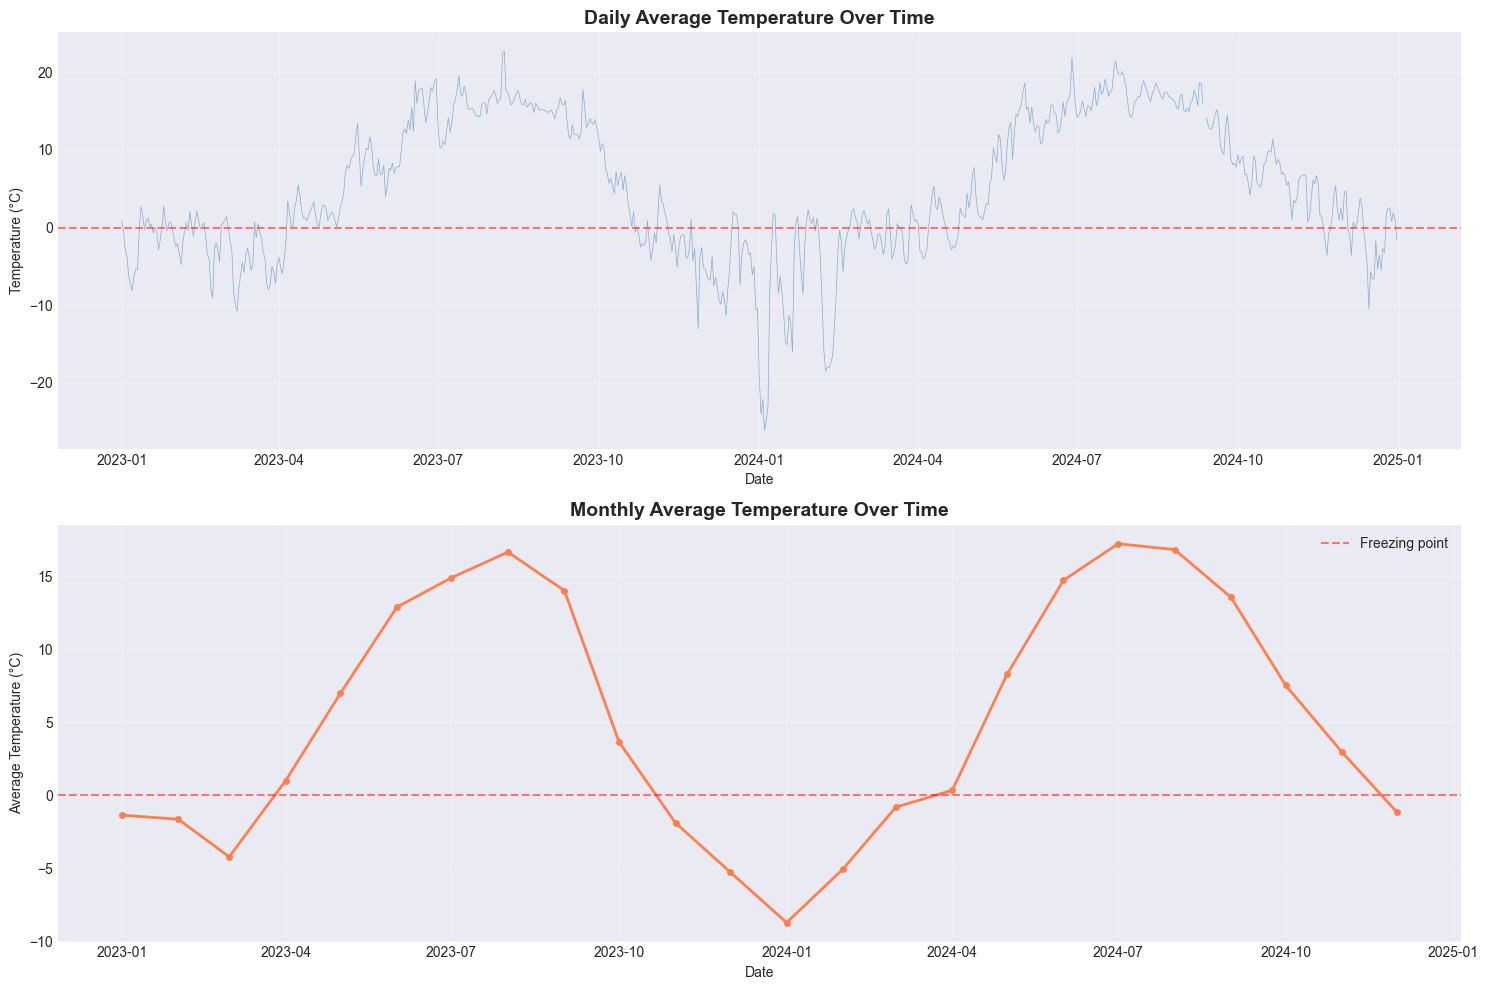

In [3]:
# 1. Temperature over time
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Daily temperature
axes[0].plot(df_clean['Date'], df_clean['Lufttemperatur_medelvärde_[°C]'], 
             alpha=0.6, linewidth=0.5, color='steelblue')
axes[0].set_title('Daily Average Temperature Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Freezing point')

# Monthly average temperature
monthly_temp = df_clean.groupby(['Year', 'Month'])['Lufttemperatur_medelvärde_[°C]'].mean().reset_index()
monthly_temp['Date'] = pd.to_datetime(
    monthly_temp['Year'].astype(str) + '-' + 
    monthly_temp['Month'].astype(str).str.zfill(2) + '-01'
)

axes[1].plot(monthly_temp['Date'], monthly_temp['Lufttemperatur_medelvärde_[°C]'], 
             marker='o', linewidth=2, markersize=4, color='coral')
axes[1].set_title('Monthly Average Temperature Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Temperature (°C)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Freezing point')
axes[1].legend()

plt.tight_layout()
plt.show()


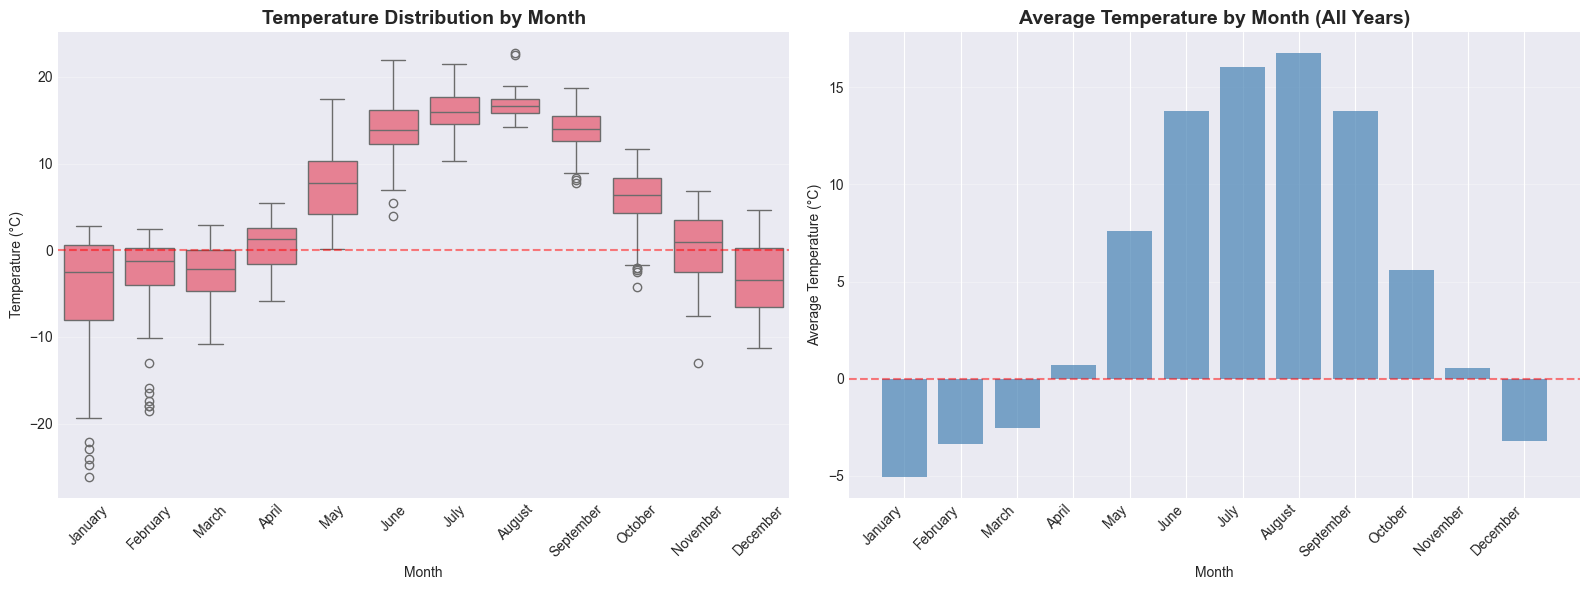

In [4]:
# 2. Seasonal patterns - Temperature by month
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df_clean['MonthName'] = pd.Categorical(df_clean['MonthName'], categories=month_order, ordered=True)

sns.boxplot(data=df_clean, x='MonthName', y='Lufttemperatur_medelvärde_[°C]', ax=axes[0])
axes[0].set_title('Temperature Distribution by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Temperature (°C)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Average temperature by month (across all years)
monthly_avg = df_clean.groupby('MonthName')['Lufttemperatur_medelvärde_[°C]'].mean().reindex(month_order)
axes[1].bar(range(len(monthly_avg)), monthly_avg.values, color='steelblue', alpha=0.7)
axes[1].set_xticks(range(len(monthly_avg)))
axes[1].set_xticklabels(monthly_avg.index, rotation=45, ha='right')
axes[1].set_title('Average Temperature by Month (All Years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Temperature (°C)')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


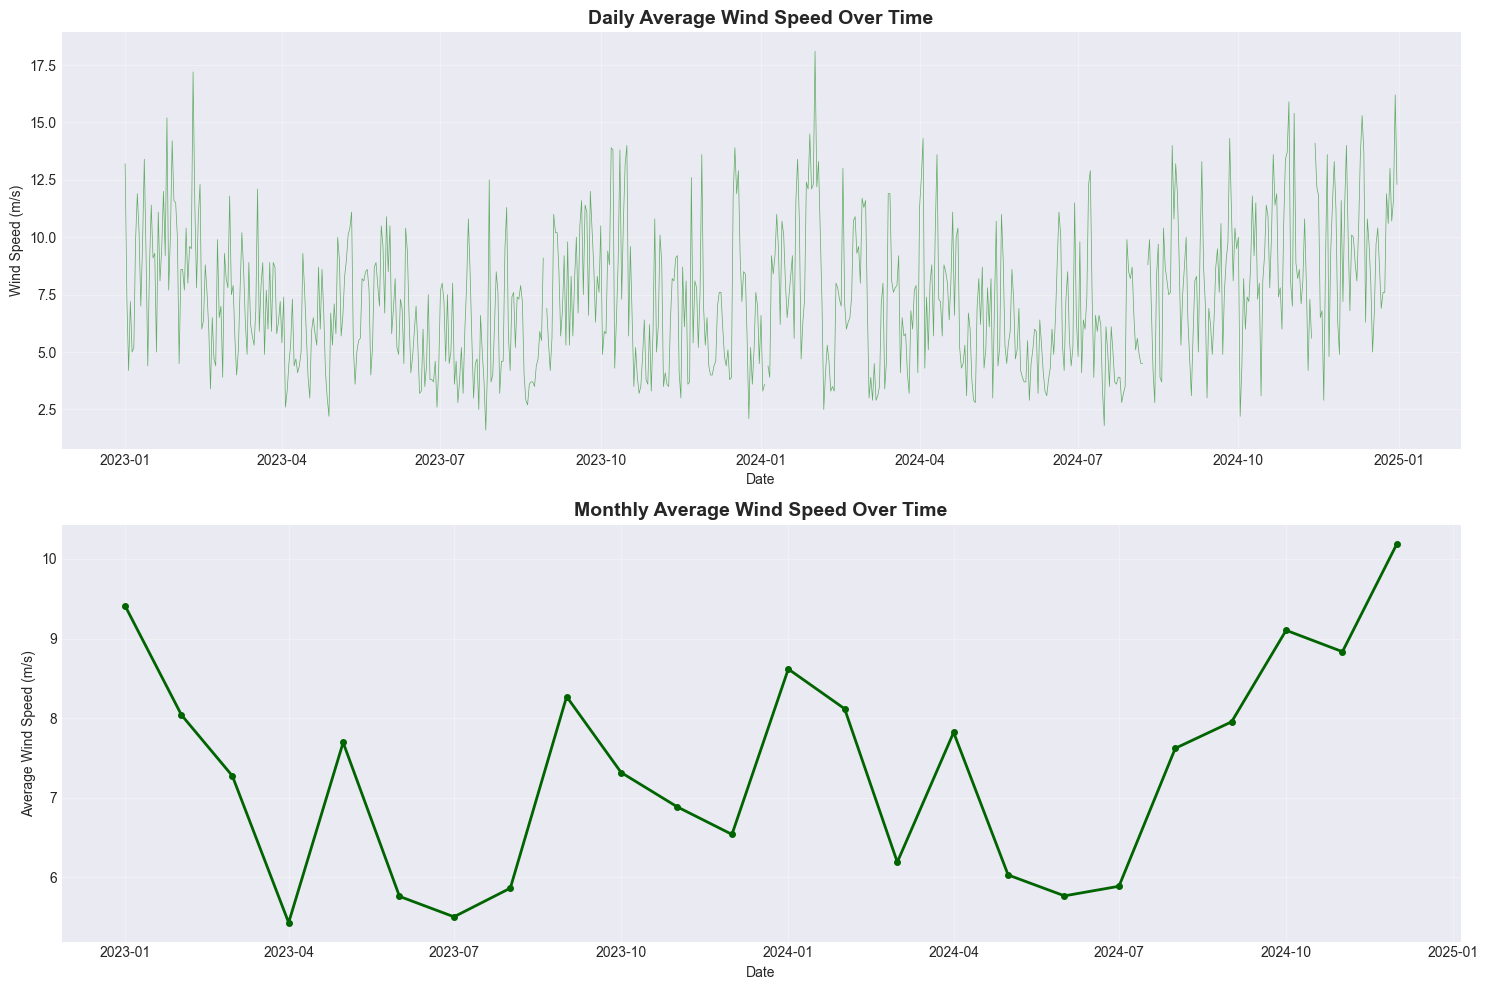

In [5]:
# 3. Wind speed analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Daily wind speed
axes[0].plot(df_clean['Date'], df_clean['Vindhastighet_medelvärde_[m/s]'], 
             alpha=0.6, linewidth=0.5, color='green')
axes[0].set_title('Daily Average Wind Speed Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Wind Speed (m/s)')
axes[0].grid(True, alpha=0.3)

# Monthly average wind speed
monthly_wind = df_clean.groupby(['Year', 'Month'])['Vindhastighet_medelvärde_[m/s]'].mean().reset_index()
monthly_wind['Date'] = pd.to_datetime(
    monthly_wind['Year'].astype(str) + '-' + 
    monthly_wind['Month'].astype(str).str.zfill(2) + '-01'
)

axes[1].plot(monthly_wind['Date'], monthly_wind['Vindhastighet_medelvärde_[m/s]'], 
             marker='o', linewidth=2, markersize=4, color='darkgreen')
axes[1].set_title('Monthly Average Wind Speed Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Wind Speed (m/s)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


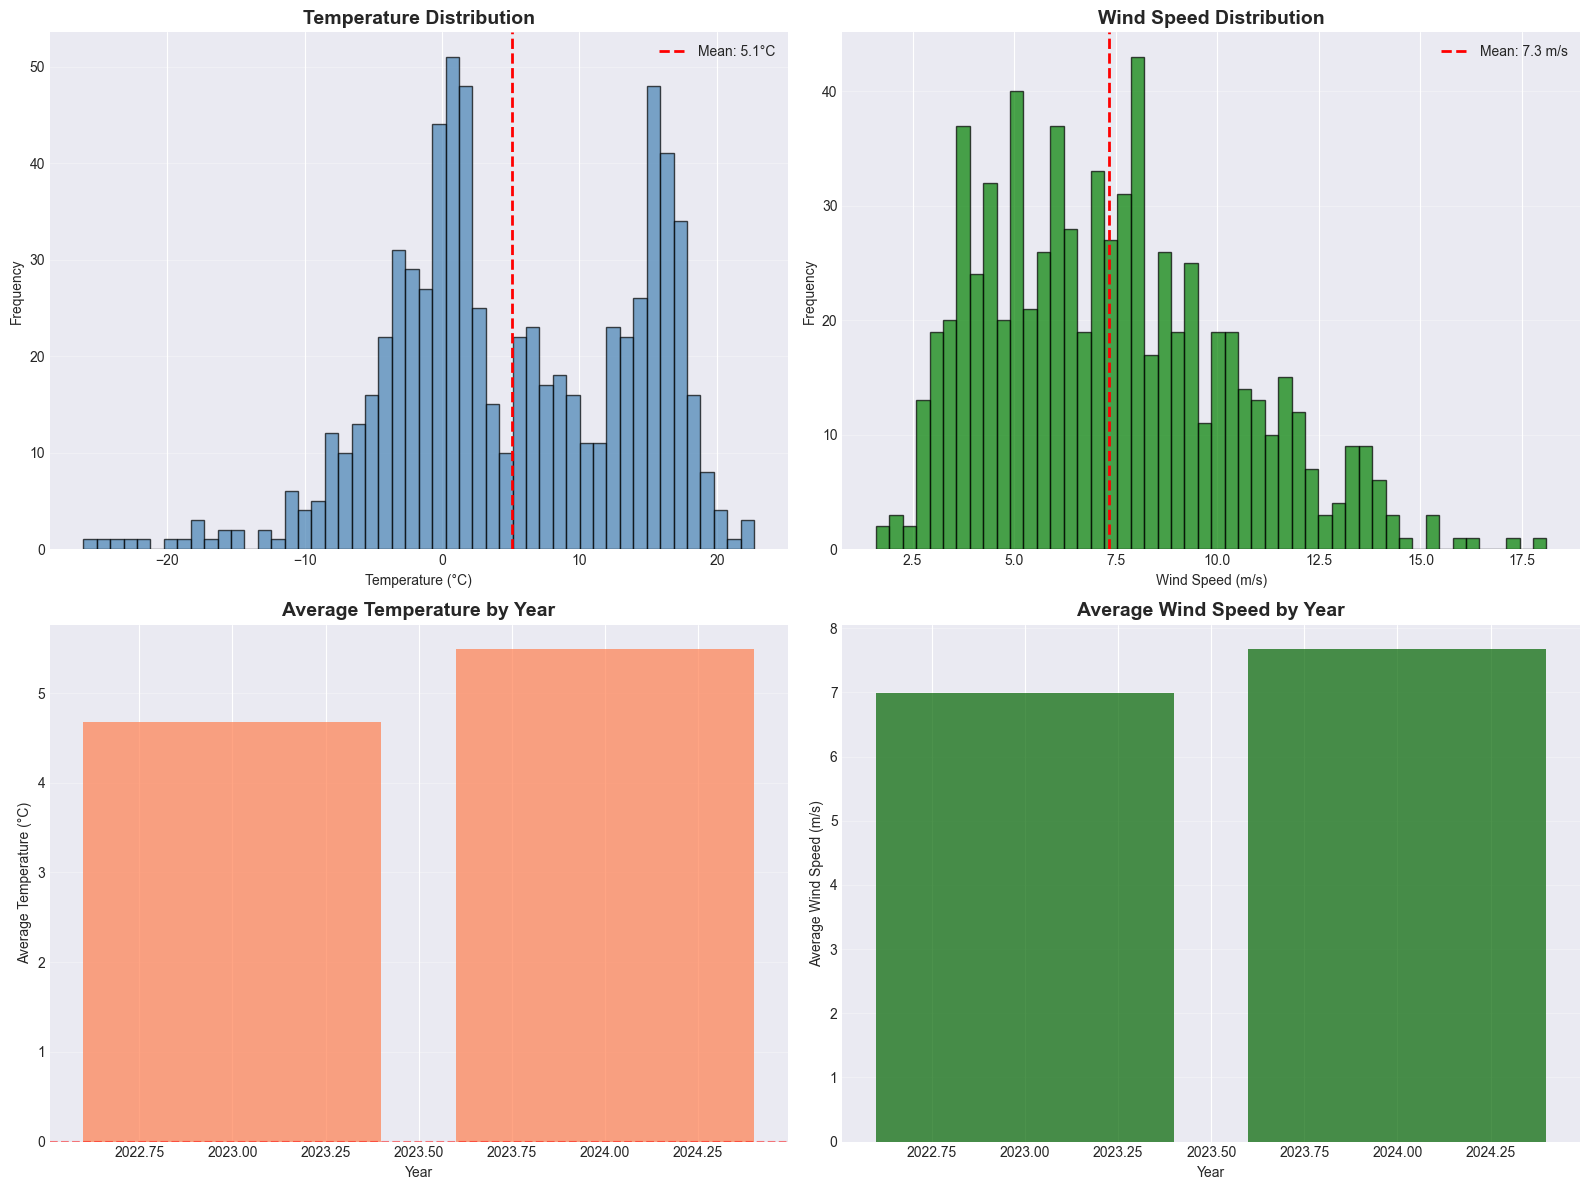

In [6]:
# 4. Temperature distribution and statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of temperature
axes[0, 0].hist(df_clean['Lufttemperatur_medelvärde_[°C]'].dropna(), bins=50, 
                color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_clean['Lufttemperatur_medelvärde_[°C]'].mean(), 
                    color='red', linestyle='--', linewidth=2, label=f'Mean: {df_clean["Lufttemperatur_medelvärde_[°C]"].mean():.1f}°C')
axes[0, 0].set_title('Temperature Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Histogram of wind speed
axes[0, 1].hist(df_clean['Vindhastighet_medelvärde_[m/s]'].dropna(), bins=50, 
                color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_clean['Vindhastighet_medelvärde_[m/s]'].mean(), 
                    color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {df_clean["Vindhastighet_medelvärde_[m/s]"].mean():.1f} m/s')
axes[0, 1].set_title('Wind Speed Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Wind Speed (m/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Temperature by year
yearly_temp = df_clean.groupby('Year')['Lufttemperatur_medelvärde_[°C]'].mean()
axes[1, 0].bar(yearly_temp.index, yearly_temp.values, color='coral', alpha=0.7)
axes[1, 0].set_title('Average Temperature by Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Temperature (°C)')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Wind speed by year
yearly_wind = df_clean.groupby('Year')['Vindhastighet_medelvärde_[m/s]'].mean()
axes[1, 1].bar(yearly_wind.index, yearly_wind.values, color='darkgreen', alpha=0.7)
axes[1, 1].set_title('Average Wind Speed by Year', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Average Wind Speed (m/s)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


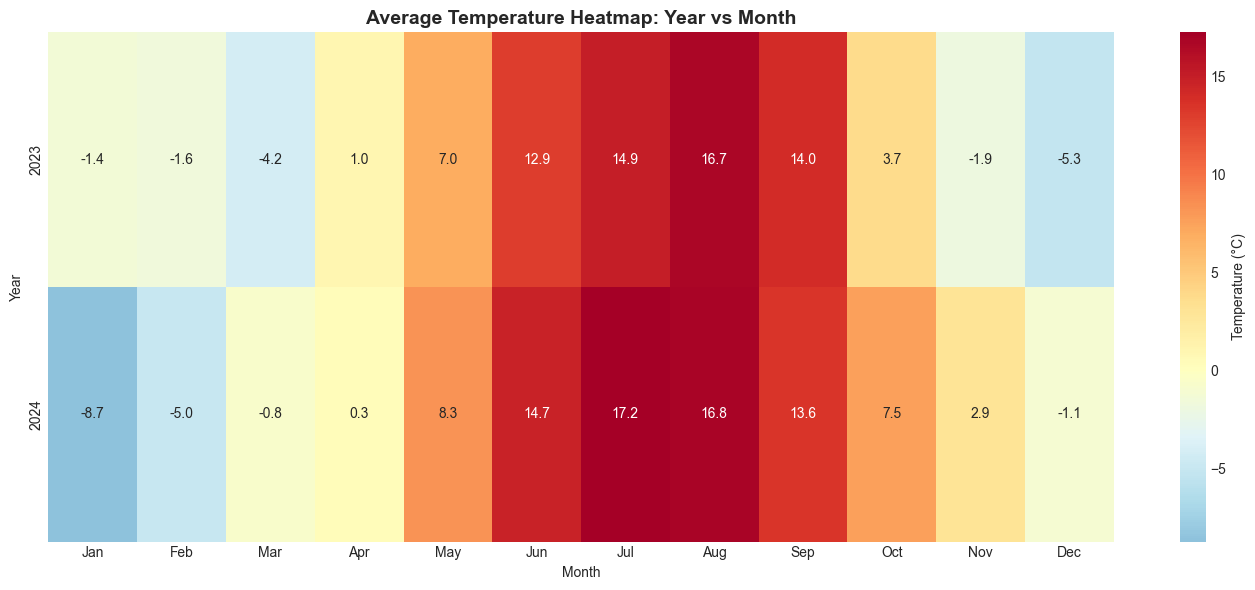

In [7]:
# 5. Heatmap - Temperature by month and year
pivot_temp = df_clean.pivot_table(
    values='Lufttemperatur_medelvärde_[°C]', 
    index='Year', 
    columns='Month', 
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pivot_temp, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            center=0, cbar_kws={'label': 'Temperature (°C)'}, ax=ax)
ax.set_title('Average Temperature Heatmap: Year vs Month', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Year')
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(month_labels)

plt.tight_layout()
plt.show()


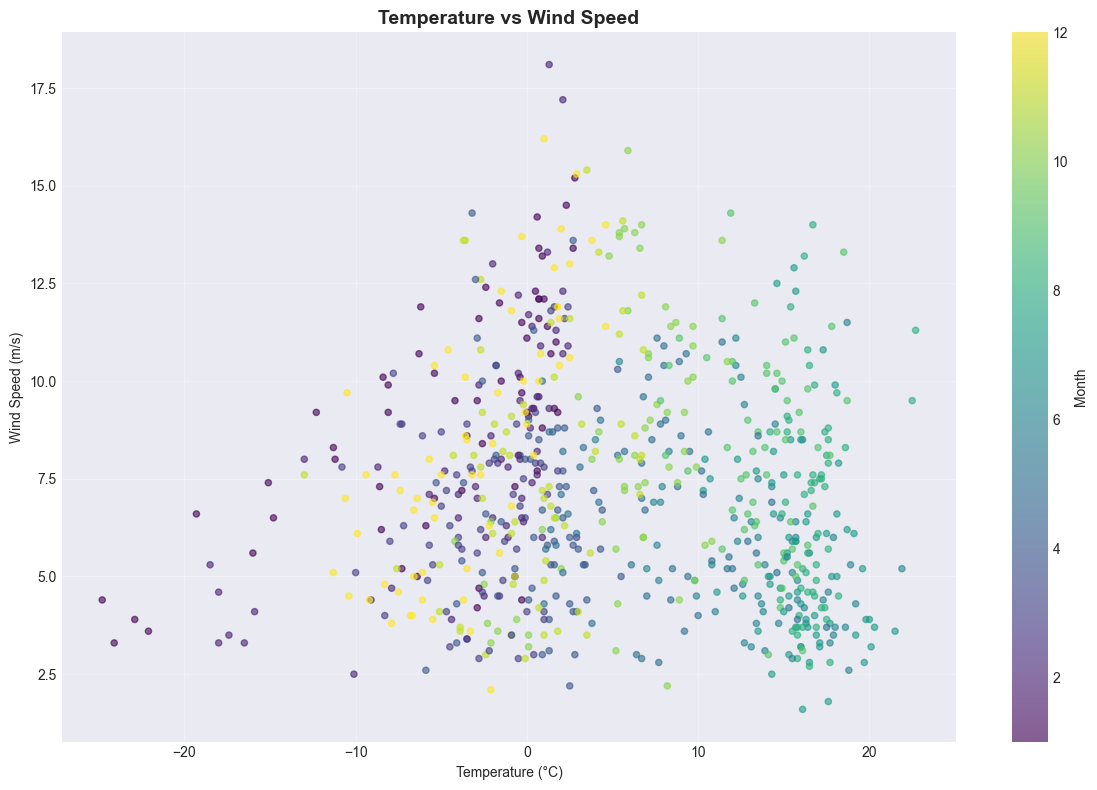

In [8]:
# 6. Temperature vs Wind Speed scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df_clean['Lufttemperatur_medelvärde_[°C]'], 
                     df_clean['Vindhastighet_medelvärde_[m/s]'],
                     c=df_clean['Month'], cmap='viridis', alpha=0.6, s=20)
ax.set_title('Temperature vs Wind Speed', fontsize=14, fontweight='bold')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Wind Speed (m/s)')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Month')

plt.tight_layout()
plt.show()


In [9]:
# 7. Summary statistics table
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print("\nTemperature Statistics:")
print(df_clean['Lufttemperatur_medelvärde_[°C]'].describe())

print("\nWind Speed Statistics:")
print(df_clean['Vindhastighet_medelvärde_[m/s]'].describe())

print("\n\nTemperature by Year:")
yearly_stats = df_clean.groupby('Year')['Lufttemperatur_medelvärde_[°C]'].agg([
    'mean', 'min', 'max', 'std'
]).round(2)
print(yearly_stats)

print("\n\nTemperature by Month (All Years):")
monthly_stats = df_clean.groupby('MonthName')['Lufttemperatur_medelvärde_[°C]'].agg([
    'mean', 'min', 'max', 'std'
]).round(2)
print(monthly_stats)


SUMMARY STATISTICS

Temperature Statistics:
count    730.000000
mean       5.081233
std        8.944231
min      -26.100000
25%       -1.100000
50%        3.450000
75%       13.900000
max       22.700000
Name: Lufttemperatur_medelvärde_[°C], dtype: float64

Wind Speed Statistics:
count    726.000000
mean       7.333058
std        2.978680
min        1.600000
25%        5.000000
50%        7.100000
75%        9.200000
max       18.100000
Name: Vindhastighet_medelvärde_[m/s], dtype: float64


Temperature by Year:
      mean   min   max   std
Year                        
2023  4.68 -13.0  22.7  8.40
2024  5.49 -26.1  21.9  9.45


Temperature by Month (All Years):
            mean   min   max   std
MonthName                         
January    -5.04 -26.1   2.8  7.60
February   -3.38 -18.5   2.4  5.80
March      -2.52 -10.8   2.9  3.25
April       0.68  -5.9   5.5  2.71
May         7.63   0.1  17.5  4.24
June       13.81   4.0  21.9  3.74
July       16.07  10.3  21.5  2.47
August     16.75